In [1]:
from transformers import Trainer, TrainingArguments, CLIPVisionConfig, CLIPTokenizerFast, CLIPProcessor
from sample4geo.dataset.vigor_plus import VigorCombinedDataset
from torchvision import transforms
import transformers
import torch

# Preprocessing and Transformations
text_processor = CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch32")

transform_val = transforms.Compose([
    transforms.Resize((348, 348)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
])

# Dataset paths and loading
dataset_root = '/home/erzurumlu.1/yunus/research_drive/data/VIGOR'  # Change to your dataset path
cities_to_include_train = ['NewYork', 'Chicago']
cities_to_include_val = ['Seattle', 'SanFrancisco']


val_dataset = VigorCombinedDataset(
    dataset_root,
    cities_to_include_val,
    transform=transform_val,
    val=True
)


/home/erzurumlu.1/miniconda3/envs/CLIP-LoRA/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/erzurumlu.1/miniconda3/envs/CLIP-LoRA/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/erzurumlu.1/miniconda3/env

In [2]:
from transformers import CLIPModel

# Data Collator function
def collate_fn(examples):
    images = [example[0] for example in examples]
    text = [example[1] for example in examples]
    text = text_processor(text, return_tensors="pt", padding=True, truncation=True)
    text['pixel_values'] = torch.stack(images)
    return text

# Model Configuration and Initialization
vision_config = CLIPVisionConfig.from_pretrained("openai/clip-vit-base-patch16", hidden_act="gelu")

class CustomCLIP(transformers.models.clip.modeling_clip.CLIPModel):
    def forward(self, **kwargs):
        return super().forward(**kwargs, interpolate_pos_encoding=True, return_loss=True)

model = CustomCLIP.from_pretrained("openai/clip-vit-base-patch16", vision_config=vision_config)

# Model Weight Loading Function
def load_model_weights(model, checkpoint_dir):
    """Load model weights from a checkpoint directory."""
    model = CLIPModel.from_pretrained(checkpoint_dir)
    return model

# Accuracy Computation Function
def compute_accuracy(model, dataset, batch_size, trials=30, checkpoint_path=None):
    if checkpoint_path:
        model = load_model_weights(model, checkpoint_path)
    
    model.eval()
    model.to('cuda' if torch.cuda.is_available() else 'cpu')
    text_processor = CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch32")

    accs = []
    with torch.no_grad():
        for t in range(trials):
            # Preparing batch data using your specified data processing
            inputs = [dataset[(t * batch_size) + i] for i in range(batch_size)]
            images = [example[0] for example in inputs]
            captions = [example[1] for example in inputs]

            text = text_processor(captions, return_tensors="pt", padding=True, truncation=True)
            text['pixel_values'] = torch.stack(images).to('cuda' if torch.cuda.is_available() else 'cpu')
            for key in text:
                text[key] = text[key].to('cuda' if torch.cuda.is_available() else 'cpu')

            outputs = model(**text, interpolate_pos_encoding=True)
            predictions = outputs.logits_per_image.softmax(dim=1).argmax(dim=1)
            accuracy = (predictions == torch.arange(batch_size, device='cuda' if torch.cuda.is_available() else 'cpu')).sum().item() / batch_size
            accs.append(accuracy)

    acc = sum(accs) / trials
    return acc

/home/erzurumlu.1/miniconda3/envs/CLIP-LoRA/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [6]:
# Example Accuracy Computation
checkpoint_path = '/home/erzurumlu.1/yunus/research_drive/language_pretrain/checkpoint-1000'  # Change to your checkpoint path
accuracy = compute_accuracy(model, val_dataset, batch_size=32, trials=30, checkpoint_path=checkpoint_path)
print(f"Model accuracy: {accuracy * 100:.2f}%")


Model accuracy: 66.88%


In [7]:
# Example Accuracy Computation
checkpoint_path = '/home/erzurumlu.1/yunus/research_drive/language_pretrain/checkpoint-1300'  # Change to your checkpoint path
accuracy = compute_accuracy(model, val_dataset, batch_size=32, trials=30, checkpoint_path=checkpoint_path)
print(f"Model accuracy: {accuracy * 100:.2f}%")


Model accuracy: 67.08%


In [3]:
# Example Accuracy Computation
checkpoint_path = '/home/erzurumlu.1/yunus/research_drive/language_pretrain/checkpoint-2000'  # Change to your checkpoint path
accuracy = compute_accuracy(model, val_dataset, batch_size=32, trials=30, checkpoint_path=checkpoint_path)
print(f"Model accuracy: {accuracy * 100:.2f}%")


Model accuracy: 70.52%


In [4]:
# Example Accuracy Computation
checkpoint_path = '/home/erzurumlu.1/yunus/research_drive/language_pretrain/checkpoint-2500'  # Change to your checkpoint path
accuracy = compute_accuracy(model, val_dataset, batch_size=32, trials=30, checkpoint_path=checkpoint_path)
print(f"Model accuracy: {accuracy * 100:.2f}%")


Model accuracy: 70.73%


In [31]:
import matplotlib.pyplot as plt
def visualize_examples(model, dataset, num_examples=15, checkpoint_dir=None):
    """Visualizes examples from the dataset along with model predictions.

    Args:
        model: The pretrained or fine-tuned CLIP model.
        dataset: The dataset to visualize examples from.
        num_examples (int): Number of examples to visualize.
        checkpoint_dir (str, optional): Path to the checkpoint directory to load weights.
    """
    if checkpoint_dir:
        model = CLIPModel.from_pretrained(checkpoint_dir)
    
    model.eval()
    model.to('cuda' if torch.cuda.is_available() else 'cpu')
    text_processor = CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch32")

    with torch.no_grad():
        for i in range(num_examples):
            # Prepare a single example
            image, caption = dataset[i]
            text = text_processor([caption], return_tensors="pt", padding=True, truncation=True)
            text['pixel_values'] = torch.unsqueeze(image, 0).to('cuda' if torch.cuda.is_available() else 'cpu')
            for key in text:
                text[key] = text[key].to('cuda' if torch.cuda.is_available() else 'cpu')

            # Model prediction
            outputs = model(**text, interpolate_pos_encoding=True)
            predictions = outputs.logits_per_image.softmax(dim=1)
            print(f"Caption: {caption}\nPrediction: {predictions}")
            # Visualize the image and prediction
            # plt.figure()
            # plt.imshow(image.permute(1, 2, 0))  # Convert image to HWC format for display
            # plt.title(f"Caption: {caption}\nPrediction: {predictions}")
            # plt.axis('off')
            # plt.show()

In [32]:
checkpoint_path = '/home/erzurumlu.1/yunus/research_drive/language_pretrain/checkpoint-500'  # Change to your checkpoint path
visualize_examples(model, val_dataset, num_examples=25, checkpoint_dir=checkpoint_path)


Caption: The satellite view shows a parking lot beside a rectangular building. Adjacent, a smaller structure lies parallel with marked parking spaces and parked cars visible. Open spaces, possibly loading zones, surround the area. The layout suggests easy ground-level navigation with distinct paths for vehicles and access points.
Prediction: tensor([[1.]], device='cuda:0')
Caption: Railway tracks run vertically through the center, bordered by an industrial area on the right. To the left, there are additional tracks and a platform. Sparse buildings and open storage spaces lie around these features. The image emphasizes an urban-industrial intersection without notable green spaces or visible roads.
Prediction: tensor([[1.]], device='cuda:0')
Caption: The satellite view highlights a residential area with houses aligned along a street. A major road runs horizontally, with parked cars alongside. A green open space, possibly a park, sits to the right. Trees are interspersed throughout, creat

In [64]:
import matplotlib.pyplot as plt
import torch
from transformers import CLIPTokenizerFast
import random

def visualize_retrieval_topk_300_optimized(model, dataset, num_images=5, top_k=5, num_captions=3000, checkpoint_dir=None):
    """Visualizes retrieval for a set number of images using top-k captions from a pre-selected subset of captions.

    Args:
        model: The pretrained or fine-tuned CLIP model.
        dataset: The dataset to visualize examples from.
        num_images (int): Number of images to visualize.
        top_k (int): Number of top captions to retrieve for each image.
        num_captions (int): Number of captions to sample for retrieval.
        checkpoint_dir (str, optional): Path to the checkpoint directory to load weights.
    """
    if checkpoint_dir:
        model = CLIPModel.from_pretrained(checkpoint_dir)
    
    model.eval()
    model.to('cuda' if torch.cuda.is_available() else 'cpu')
    text_processor = CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch32")

    # Pre-sample a subset of captions from the dataset
    all_indices = list(range(len(dataset)))
    sampled_indices = random.sample(all_indices, min(num_captions, len(all_indices)))
    # sample the last 300 images
    # sampled_indices = all_indices[:num_captions]
    sampled_captions = [dataset[idx][1] for idx in sampled_indices]

    random_indices = random.sample(range(len(dataset)), num_images)
    with torch.no_grad():
        for i in range(num_images):
            # Select an image and its GT caption from the dataset
            image, gt_caption = dataset[random_indices[i]]
            image = image.unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')

            # Ensure the GT caption is included in the sampled captions
            if gt_caption not in sampled_captions:
                sampled_captions[-1] = gt_caption  # Replace the last element to ensure GT inclusion

            # Process the captions
            text_inputs = text_processor(sampled_captions, return_tensors="pt", padding=True, truncation=True)
            for key in text_inputs:
                text_inputs[key] = text_inputs[key].to('cuda' if torch.cuda.is_available() else 'cpu')

            # Add the image to text inputs
            text_inputs['pixel_values'] = image.repeat(len(sampled_captions), 1, 1, 1)  # Repeat image for comparison

            # Model forward pass
            outputs = model(**text_inputs, interpolate_pos_encoding=True)
            logits_per_image = outputs.logits_per_image.squeeze(0)  # Shape: [num_captions]
            top_k_indices = logits_per_image.topk(top_k).indices.cpu().tolist()

            # Visualization
            plt.figure()
            plt.imshow(image.cpu().squeeze().permute(1, 2, 0))  # Convert image to HWC format for display
            plt.title(f"Example {i+1}: Top Retrieved Captions")
            plt.axis('off')
            plt.show()

            # Display the top-k retrieved captions
            print(f"Example {i+1} - Ground Truth Caption: {gt_caption}")
            print("Top Retrieved Captions:")
            top_k_indices = top_k_indices[0]
            for rank, idx in enumerate(top_k_indices):
                
                print(f"{rank + 1}: {sampled_captions[int(idx)]}")  # Ensure idx is converted to integer


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.117457].


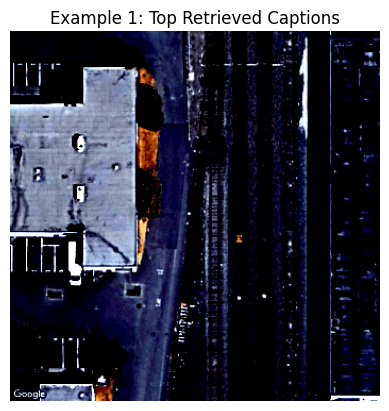

Example 1 - Ground Truth Caption: In a satellite view, railroad tracks run vertically, adjacent to two large rectangular buildings, with parking lots visible below. Trees line the edges, providing green spaces. Roads cross diagonally across the view, integrating urban structures with natural features, showing a blend of industrial and urban settings.
Top Retrieved Captions:
1: In a satellite view, railroad tracks run vertically, adjacent to two large rectangular buildings, with parking lots visible below. Trees line the edges, providing green spaces. Roads cross diagonally across the view, integrating urban structures with natural features, showing a blend of industrial and urban settings.
2: A railway line runs vertically with tracks and a station, split by two platforms. To the left, a wide road intersects the tracks, bordered by trees and parking lots. Buildings, parking spaces, and a small cluster of trees occupy the lower section, while greenery and empty spaces border the top-lef

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].


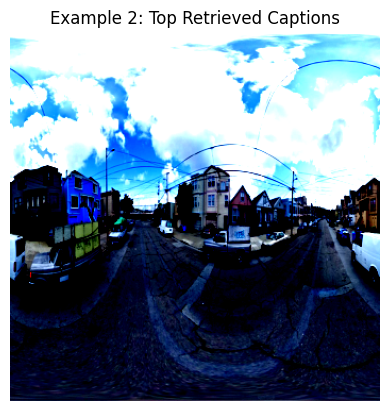

Example 2 - Ground Truth Caption: A residential neighborhood showcases a grid-like street layout with intersections. Notable are closely packed houses and parked cars lining both sides of the roads. Power lines crisscross overhead. The open sky above contrasts the compact urban setting, with no visible parks or natural features intersecting the urban landscape.
Top Retrieved Captions:
1: A residential neighborhood showcases a grid-like street layout with intersections. Notable are closely packed houses and parked cars lining both sides of the roads. Power lines crisscross overhead. The open sky above contrasts the compact urban setting, with no visible parks or natural features intersecting the urban landscape.
2: An intersection with two intersecting roads is surrounded by multi-story residential buildings. To the left, a dark blue building stands, while a beige building is on the right. Cars line the street, and utility poles with overhead wires crisscross above. The scene lacks nota

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7776641..2.103237].


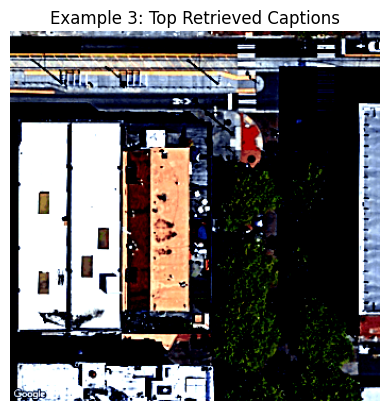

Example 3 - Ground Truth Caption: The image shows a rectangular building with a reddish roof, bordered by roads and lush trees. To the left, a broad street runs parallel to the building. In front, a smaller road intersects. Trees fill the bottom-right space, and a visible sidewalk adjoins the top road.
Top Retrieved Captions:
1: The image features a grid-like street layout with a prominent intersection in the top right. Several rectangular buildings line the streets, with trees interspersed. Parking is parallel to the buildings. A small pocket of greenery is visible, possibly a small park or open space.
2: The image shows a grid-like street layout with rectangular, flat-roofed buildings. A major intersection features prominently near the center. Parking is available along the streets, with trees lining the area. Buildings are positioned close to the roads, creating a dense urban environment with minimal open green spaces.
3: The image shows a rectangular building with a reddish roof, b

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6470428..2.0463567].


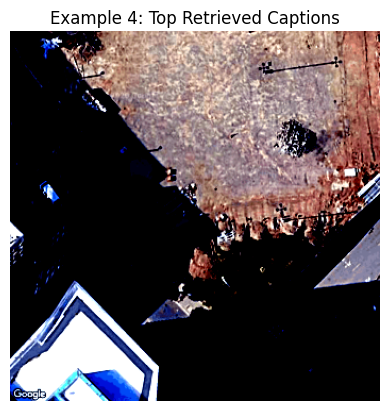

Example 4 - Ground Truth Caption: A large, open construction site dominates the center. Nearby roads curve around, creating multiple intersections. A distinctive L-shaped building is prominent at the bottom-left. Small clusters of greenery appear at the site's edges, while adjacent streets host minimal traffic. Shadows indicate a few tall structures nearby.
Top Retrieved Captions:
1: A large, open construction site dominates the center. Nearby roads curve around, creating multiple intersections. A distinctive L-shaped building is prominent at the bottom-left. Small clusters of greenery appear at the site's edges, while adjacent streets host minimal traffic. Shadows indicate a few tall structures nearby.
2: In the image, a large construction site with visible steel frameworks dominates the center. Major roads intersect at the top right, with clear crosswalks. A triangular green area is visible near the intersection. The layout suggests urban development with a focus on structural expans

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.1316772].


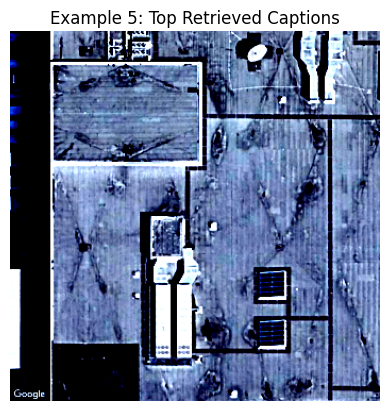

Example 5 - Ground Truth Caption: Aerial view displays a flat, rectangular rooftop with large HVAC units and ventilation systems positioned centrally. The layout shows minimal road networks or natural features nearby, resembling an industrial area from a high vantage. The rooftop's elements would dominate a ground-level perspective with little surrounding context.
Top Retrieved Captions:
1: The image shows a large rectangular building with a white roof, likely a warehouse. To the top, several loading docks with trucks are aligned. A parking lot is right, bordered by greenery. The warehouse is central, with open spaces and roads surrounding it, emphasizing industrial functionality.
2: A large rectangular building dominates the area, flanked by parking lots on the right with white-lined spaces. The structure has a flat roof with visible rooftop structures. Adjacent open spaces lack greenery, focusing on industrial use, and no significant natural features intersect the urban layout.
3: Ae

In [65]:
# Example Usage
checkpoint_path = '/home/erzurumlu.1/yunus/research_drive/language_pretrain/checkpoint-500'  # Change to your checkpoint path
visualize_retrieval_topk_300_optimized(model, val_dataset, num_images=5, top_k=5, num_captions=300, checkpoint_dir=checkpoint_path)
